## Chest pathology detection


### Initialize TensorFlow 2.0 and Mount the google drive to consume data

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
# Initialize the random number generator
import random
from tensorflow.keras import utils
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# In order to use tqdm progress bar library....
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [0]:
# run this cell to to mount the google drive if you are using google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np

Store the train/test and all csv files in google drive instead of storing in the VM for faster access. Also we will not lose train/test directories when the VM is reallocated..

In [0]:
src_dir_path = '/content/drive/My Drive/Capstone/processed_data/lungs-xray-data1024px/'
parent_train_dir = "/content/train/"
train_data_dir = "/content/trainX/"
val_data_dir = "/content/valX"

test_data_dir = "/content/test/" # Not used for now.

num_classes = 3

In [0]:
!ls '/content/drive/My Drive/Capstone/processed_data/lungs-xray-data1024px/'

test_COVIDx_v1.txt  train-001.zip  train-003.zip
test.zip	    train-002.zip  train_COVIDx_v1.txt


### Unzip the Dataset Files (One time execution until the lifetime of the colab container)

In [0]:
from zipfile import ZipFile

# There are 3 train files
with ZipFile(src_dir_path+'train-001.zip', 'r') as z:
  z.extractall()

with ZipFile(src_dir_path+'train-002.zip', 'r') as z:
  z.extractall()

with ZipFile(src_dir_path+'train-003.zip', 'r') as z:
  z.extractall()

In [0]:
!ls '/content/train' | wc -l

13497


Repeat the same step for test.zip

In [0]:
# Test file
with ZipFile(src_dir_path+'test.zip', 'r') as z:
  z.extractall()

In [0]:
!ls '/content/test' | wc -l

1489


### Read the Train and Test csv file using pandas

In [0]:
import pandas as pd

lungxray_train_df = pd.read_csv(src_dir_path + 'train_COVIDx_v1.txt',delimiter=' ', names=['patient_id', 'xray_img_name', 'target_class'])
lungxray_train_df.shape

(16546, 3)

In [0]:
lungxray_train_df.head()

,patient_id,xray_img_name,target_class
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [0]:
lungxray_train_df.nunique()['xray_img_name']

13467

30 images are either duplicate or augumented with same name. Examine these images by plotting (Need to do more EDA)

In [0]:
lungxray_test_df = pd.read_csv(src_dir_path + 'test_COVIDx_v1.txt',delimiter=' ', names=['patient_id', 'xray_img_name', 'target_class'])
lungxray_test_df.shape

(210, 3)

In [0]:
lungxray_test_df.head()

,patient_id,xray_img_name,target_class
0,47c78742-4998-4878-aec4-37b11b1354ac,47c78742-4998-4878-aec4-37b11b1354ac.png,normal
1,8989e25c-a698-48fc-b428-fff56931fc8f,8989e25c-a698-48fc-b428-fff56931fc8f.png,normal
2,7fb3786c-5045-4a90-981d-c55b53d4d5d3,7fb3786c-5045-4a90-981d-c55b53d4d5d3.png,normal
3,766b8aea-3b43-4a34-b675-09f373ca066b,766b8aea-3b43-4a34-b675-09f373ca066b.png,normal
4,f6236cb5-cc36-4ec4-895c-d11ce043341d,f6236cb5-cc36-4ec4-895c-d11ce043341d.png,normal


### Split the train data in the labels.csv into train and validation dataframes. (Using Stratify)

This is prep work for to use tensor flow 2.0 API's. Tensor flow uses this dataframe to train the model in batches

In [0]:
# Train / Validation split on the dog_labels_df
# Split train data into training and validation.
from sklearn.model_selection import train_test_split

trn_df, val_df = train_test_split(lungxray_train_df, test_size=0.2, random_state=50, 
                                  stratify=lungxray_train_df['target_class'])
#trn_df['xray_img_name'] = trn_df['xray_img_name'] + ".jpg"
#val_df['xray_img_name'] = val_df['xray_img_name'] + ".jpg"

print(trn_df.shape)
print(val_df.shape)

(13236, 3)
(3310, 3)


In [0]:
trn_df.shape
val_df.shape

(3310, 3)

### Block to split train into trainX and valX images to facilitate flow_from_dataframe calls

This will be done based on trn_df and val_df dataframes

In [0]:
import os

def create_dir_in_colab_runtime(path):
  # define the name of the directory to be created
  # define the access rights
  access_rights = 0o755

  try:
      os.mkdir(path, access_rights)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s" % path)
  return

In [0]:
# importing shutil module  
import shutil
import os
import sys

# Source path  
src_dir = '/content/train/'  
# Destination paths  
new_train_dir = '/content/trainX/'
new_val_dir = '/content/valX/'

create_dir_in_colab_runtime(new_train_dir)
create_dir_in_colab_runtime(new_val_dir)

# Before copying check the number of files in TRAIN directory
src_path, src_dirs, src_files = next(os.walk(src_dir))
src_file_count = len(src_files)
print("train file counts :", src_file_count)

# Move the data from train into trainX and valX 
# Keep the original train as is to maintain the data integrity for future experiments

with tqdm(total=len(trn_df['xray_img_name'].values), file=sys.stdout) as pbar:
  for s in trn_df['xray_img_name'].values:
    pbar.update(1)
    new_trn_path = shutil.copy(src_dir + s, new_train_dir)
pbar.close()

with tqdm(total=len(val_df['xray_img_name'].values), file=sys.stdout) as pbar:
  for t in val_df['xray_img_name'].values:
    pbar.update(1)
    new_val_path = shutil.copy(src_dir + t, new_val_dir)
pbar.close()

trn_path, trn_dirs, trn_files = next(os.walk(new_train_dir))
trn_file_count = len(trn_files)

val_path, val_dirs, val_files = next(os.walk(new_val_dir))
val_file_count = len(val_files)

print("TrainX file count :", trn_file_count)
print("valX file count :", val_file_count)

Successfully created the directory /content/trainX/
Successfully created the directory /content/valX/
train file counts : 13497



TrainX file count : 11248
valX file count : 3182


In [0]:
!ls '/content/valX' | wc -l

3182


In [0]:
!ls -l '/content/train/0a13f9596e03a9f87c96aaff6e057048.jpg'

ls: cannot access '/content/train/0a13f9596e03a9f87c96aaff6e057048.jpg': No such file or directory


### Print the count of each category of chest pathology given in the dataset



In [0]:
lungxray_train_df.groupby('target_class').count()

,patient_id,xray_img_name
target_class,,
COVID-19,66,66
normal,7966,7966
pneumonia,8514,8514


### Common functions required for all models
* Plot accuracy loss
* Round_up

In [0]:
import math

def plot_train_val_accuracy(history,title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
  plt.show()


def plot_train_accuracy(history,title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy'], loc='best')
  plt.show()


def plot_train_val_loss(history,title):
  plt.title(title)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'validation_loss'], loc='best')
  plt.show()

def plot_train_loss(history,title):
  plt.title(title)
  plt.plot(history.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss'], loc='best')
  plt.show()

def round_up(n, decimals=0): 
  multiplier = 10 ** decimals 
  return math.ceil(n * multiplier) / multiplier

### Transfer Learning - Using VGG16
* Use VGG16 weights ( downloaded )
* Trained on ImageNet
* No pixel normalization


*VGG16 uses input image size of 224. Provide the inputs in this resolution* 

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

# Instantiate the model with the pre-trained weights (no top)
#base_model= VGG16(weights=(src_dir_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
#                  include_top=False, pooling='avg', input_shape=(224,224,3))


base_model= VGG16(weights='imagenet',
                  include_top=False, 
                  pooling='avg', 
                  input_shape=(224,224,3))

# Take a look at the model summary
base_model.summary()

layer_count=0
# mark loaded layers as not trainable
for layer in base_model.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_model.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [0]:
img_height = 224
img_width = 224
batch_size = 32
epochs = 10

Run this block to execute both training & validation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

# Train data - prepare data augmentation configuration 
#train_datagen = ImageDataGenerator()

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=trn_df, 
    directory=train_data_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Test data - Get it ready - No augumentation
#valid_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

#valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df, 
    directory=val_data_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=round_up(valid_generator.n/valid_generator.batch_size)

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=epochs)

plot_train_val_accuracy(history, "VGG tf2 - Accuracy")
plot_train_val_loss(history, "VGG tf2 - Loss")

NameError: ignored

Run the full model without validation (to make the model more robust )

Found 16546 validated image filenames belonging to 3 classes.
518.0
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
518/518 [==============================] - 386s 745ms/step - loss: 0.5652 - accuracy: 0.8282
Epoch 2/10
518/518 [==============================] - 345s 666ms/step - loss: 0.3545 - accuracy: 0.8656
Epoch 3/10
518/518 [==============================] - 337s 651ms/step - loss: 0.3384 - accuracy: 0.8673
Epoch 4/10
518/518 [==============================] - 340s 656ms/step - loss: 0.3280 - accuracy: 0.8703
Epoch 5/10
518/518 [==============================] - 340s 657ms/step - loss: 0.3311 - accuracy: 0.8717
Epoch 6/10
518/518 [==============================] - 337s 651ms/step - loss: 0.3208 - accuracy: 0.8730
Epoch 7/10
518/518 [==============================] - 339s 654ms/step - loss: 0.3189 - accuracy: 0.8768
Epoch 8/10
518/518 [==============================] - 339s 654ms/step - loss: 0.3205 - accuracy: 0.8744
Epoch 9/10
518/518 [====

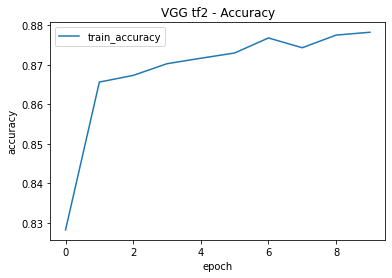

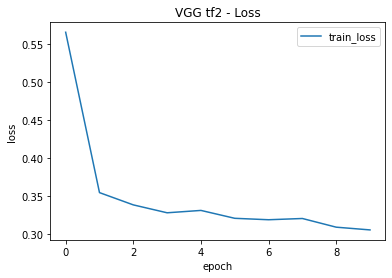

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=parent_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "VGG tf2 - Accuracy")
plot_train_loss(history, "VGG tf2 - Loss")

Print the Test loss, accuracy and confusion matrix

In [0]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=test_data_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 210 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
Instructions for updating:
Please use Model.evaluate, which supports generators.
7/7 [==============================] - 5s 729ms/step - loss: 0.4216 - accuracy: 0.8714
Accuracy: 0.871
Loss: 0.422
Instructions for updating:
Please use Model.predict, which supports generators.
7/7 [==============================] - 2s 339ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 0  1  9]
 [ 0 94  6]
 [ 0 11 89]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.89      0.94      0.91       100
           2       0.86      0.89      0.87       100

    accuracy                           0.87       210
   macro avg       0.58      0.61      0.60       210
weighted avg       0.83      0.87      0.85       210



In [0]:
y_predict.shape

(210, 3)

### Use Resnet50

* Import Resnet50 from tensorflow.keras.applications
* Implement the dense layer as per the dogbreed classification usecase with 120 classes output
* Compile the new model


In [0]:
img_height = 224
img_width = 224
batch_size = 32
epochs = 10
num_classes = 3

In [0]:
# Use tf.keras.applications to refer the model directly....(DONNOT DOWNLOAD !)
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

base_resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='imagenet')

# mark loaded layers as not trainable
#base_resnet50.trainable = False

print(base_resnet50.summary())

layer_count=0
# mark loaded layers as not trainable
for layer in base_resnet50.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_resnet50.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_resnet50.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

* Read images from the VM and perform normalization
* Stream the images from train directory for training
* Evaluate the validation accuracy..

Found 16546 validated image filenames belonging to 3 classes.
518.0
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
518/518 [==============================] - 375s 724ms/step - loss: 0.5125 - accuracy: 0.8509
Epoch 2/10
518/518 [==============================] - 329s 636ms/step - loss: 0.3124 - accuracy: 0.8858
Epoch 3/10
518/518 [==============================] - 323s 623ms/step - loss: 0.2905 - accuracy: 0.8910
Epoch 4/10
518/518 [==============================] - 323s 624ms/step - loss: 0.2922 - accuracy: 0.8872
Epoch 5/10
518/518 [==============================] - 324s 626ms/step - loss: 0.2819 - accuracy: 0.8926
Epoch 6/10
518/518 [==============================] - 324s 626ms/step - loss: 0.2840 - accuracy: 0.8913
Epoch 7/10
518/518 [==============================] - 326s 630ms/step - loss: 0.2748 - accuracy: 0.8942
Epoch 8/10
518/518 [==============================] - 325s 628ms/step - loss: 0.2716 - accuracy: 0.8953
Epoch 9/10
518/518 [====

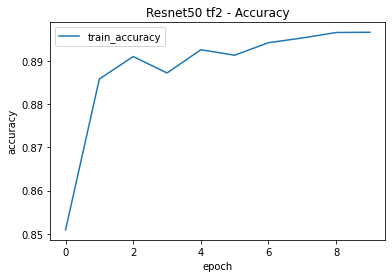

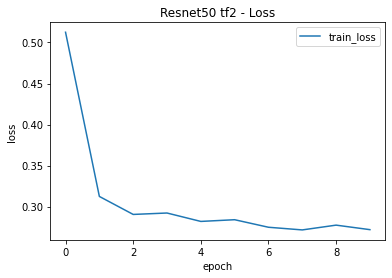

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')


# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=parent_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Resnet50 tf2 - Accuracy")
plot_train_loss(history, "Resnet50 tf2 - Loss")

In [0]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=test_data_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 210 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
7/7 [==============================] - 2s 299ms/step - loss: 0.4273 - accuracy: 0.8857
Accuracy: 0.886
Loss: 0.427
7/7 [==============================] - 2s 296ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 0  6  4]
 [ 0 97  3]
 [ 0 11 89]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.85      0.97      0.91       100
           2       0.93      0.89      0.91       100

    accuracy                           0.89       210
   macro avg       0.59      0.62      0.60       210
weighted avg       0.85      0.89      0.86       210



### InceptionV3 net

In [0]:
img_height = 299
img_width = 299
batch_size = 32
epochs = 10
num_classes = 3

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

base_inceptionv3 = InceptionV3(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')

# mark loaded layers as not trainable
#base_resnet50.trainable = False

print(base_inceptionv3.summary())

layer_count=0
# mark loaded layers as not trainable
for layer in base_inceptionv3.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_inceptionv3.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_inceptionv3.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_194[0][0]    
_______________________________________________________________________________________

Found 16546 validated image filenames belonging to 3 classes.
518.0
Epoch 1/10
518/518 [==============================] - 487s 941ms/step - loss: 0.5497 - accuracy: 0.8364
Epoch 2/10
518/518 [==============================] - 448s 865ms/step - loss: 0.3355 - accuracy: 0.8694
Epoch 3/10
518/518 [==============================] - 435s 841ms/step - loss: 0.3159 - accuracy: 0.8804
Epoch 4/10
518/518 [==============================] - 438s 845ms/step - loss: 0.3141 - accuracy: 0.8778
Epoch 5/10
518/518 [==============================] - 443s 856ms/step - loss: 0.3032 - accuracy: 0.8799
Epoch 6/10
518/518 [==============================] - 452s 872ms/step - loss: 0.3048 - accuracy: 0.8826
Epoch 7/10
518/518 [==============================] - 452s 872ms/step - loss: 0.3018 - accuracy: 0.8858
Epoch 8/10
518/518 [==============================] - 448s 866ms/step - loss: 0.3020 - accuracy: 0.8818
Epoch 9/10
518/518 [==============================] - 449s 867ms/step - loss: 0.2954 - accuracy: 0.8

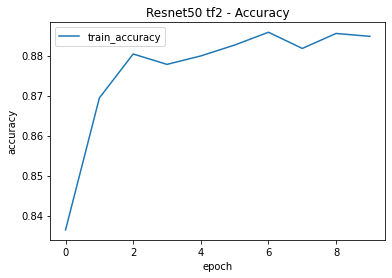

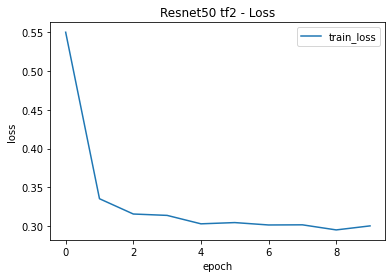

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')


# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=parent_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Inceptionv3 tf2 - Accuracy")
plot_train_loss(history, "Inceptionv3 tf2 - Loss")

In [0]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=test_data_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 210 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
Instructions for updating:
Please use Model.evaluate, which supports generators.
7/7 [==============================] - 5s 660ms/step - loss: 0.4922 - accuracy: 0.8571
Accuracy: 0.857
Loss: 0.492
Instructions for updating:
Please use Model.predict, which supports generators.
7/7 [==============================] - 2s 326ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 0  6  4]
 [ 0 91  9]
 [ 0 11 89]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.84      0.91      0.87       100
           2       0.87      0.89      0.88       100

    accuracy                           0.86       210
   macro avg       0.57      0.60      0.59       210
weighted avg       0.82      0.86      0.84       210



### MobileNetV2 ( Recommended for Classification, Detection and Segmentation of images ) - Designed for Edge devices 

In [0]:
img_height = 224
img_width = 224
batch_size = 32 # default batch size 
#batch_size = 96 # Also try with batch size 96 as per documentation
epochs = 50
num_classes = 3

In [0]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

base_mobilenetv2 = MobileNetV2(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')

# mark loaded layers as not trainable
#base_resnet50.trainable = False

print(base_mobilenetv2.summary())

layer_count=0
# mark loaded layers as not trainable
for layer in base_mobilenetv2.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_mobilenetv2.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

x = layers.Dense(1280, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_mobilenetv2.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)


'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')
'''

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=parent_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Mobilenet V2 - Accuracy")
plot_train_loss(history, "Mobilenet V2 - Loss")

Found 16546 validated image filenames belonging to 3 classes.
518.0
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
518/518 [==============================] - 267s 515ms/step - loss: 0.5135 - accuracy: 0.8459
Epoch 2/50
518/518 [==============================] - 217s 420ms/step - loss: 0.3148 - accuracy: 0.8795
Epoch 3/50
518/518 [==============================] - 214s 414ms/step - loss: 0.2958 - accuracy: 0.8845
Epoch 4/50
518/518 [==============================] - 214s 413ms/step - loss: 0.2890 - accuracy: 0.8892
Epoch 5/50
518/518 [==============================] - 214s 413ms/step - loss: 0.2746 - accuracy: 0.8908
Epoch 6/50
518/518 [==============================] - 215s 415ms/step - loss: 0.2803 - accuracy: 0.8919
Epoch 7/50
518/518 [==============================] - 214s 413ms/step - loss: 0.2771 - accuracy: 0.8934
Epoch 8/50
518/518 [==============================] - 214s 413ms/step - loss: 0.2700 - accuracy: 0.8947
Epoch 9/50
518/518 [====

NameError: ignored

In [0]:
# Print the loss and accuracy
from sklearn import metrics
import numpy as np
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=test_data_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 210 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
7/7 [==============================] - 3s 366ms/step - loss: 0.5614 - accuracy: 0.8714
Accuracy: 0.871
Loss: 0.561
7/7 [==============================] - 3s 364ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 1  4  5]
 [ 0 93  7]
 [ 0 11 89]]
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.86      0.93      0.89       100
           2       0.88      0.89      0.89       100

    accuracy                           0.87       210
   macro avg       0.91      0.64      0.65       210
weighted avg       0.88      0.87      0.86       210

